# Explanation

This file measured how a phone behaved when it was more or less at rest. The pitch and yaw are calculated by estimating what pitch and yaw would be required to get the accelerometers to pick up the earth's gravity vector in the way that it is currently picking it up.

This code was also used in an attempt to debug the rotation state process equations

In [469]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

inv = np.linalg.inv

In [470]:
filename = 'ios/rotation-through-g-field.csv'
filename = 'ios/rotation-along-principle-axes.csv'
t, _, _, _, ax, ay, az, _, gx, gy, gz, _, magx, magy, magz, _, _, alt, _  = pd.read_csv(filename).values.T

In [636]:
filename = 'ios/rotation-through-g-field.csv'
fields = pd.read_csv('ios/shake-with-gps.csv').columns
filename = 'ios/sit-on-couch.csv'
(t, _, _,location_timestamp,
latitude, longitude, altitude,
 _, _, vertical_accuracy, horizontal_accuracy, _, 
at, ax, ay, az,
gt, gx, gy, gz,
_, magx, magy, magz,
_, _, alt, _,
) = pd.read_csv(filename)[fields].values.T[:,::10]

In [637]:
t = pd.to_datetime(t)

In [638]:
dt = ((t[-1] - t[0]) / (len(t) - 1)).value / 1e9

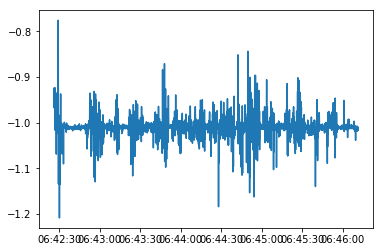

In [639]:
plt.plot(t, az)

In [640]:
def R_(yaw, pitch, roll):
    """http://planning.cs.uiuc.edu/node102.html"""
    """Performs first roll, then pitch, then yaw"""
    """a : alpha, yaw"""
    """b: beta, pitch"""
    """r: gamma, roll"""
    ca = np.cos(yaw)
    cb = np.cos(pitch)
    cg = np.cos(roll)
    sa = np.sin(yaw)
    sb = np.sin(pitch)
    sg = np.sin(roll)
    
    
    yR = np.array([
        [ca, sa, 0],
        [-sa, ca, 0],
        [0, 0, 1]
    ])
    
    pR = np.array([
        [1, 0, 0],
        [0, cb, sb],
        [0, -sb, cb]
    ])
    
    rR = np.array([
        [cg, 0, -sg],
        [0, 1, 0],
        [sg, 0, cg]
    ])
    
    return rR @ pR @ yR
    return np.array([
        [ca*cg - sa*sb*sg, cg*sa + ca*sb*sg, -cb*sg],
        [-cb*sa, ca*cb, sb],
        [cg*sa*sb + ca*sg, -ca*cg*sb + sa*sg, cb*cg]
    ])

def get_yaw_pitch_roll_from_R(R):
    """https://math.stackexchange.com/a/2802520"""
    yaw = np.angle(-1j*R[1,0] + R[1,1])
    pitch = np.arcsin(R[1,2])
    roll = np.arctan(-R[0,2]/R[2,2])
    
    return yaw, pitch, roll

def h(mu):
    pitch, roll = mu
    return R_(0, pitch, roll) @ np.array([0, 0, -1])

In [641]:
np.around(h((.5, .5)), 2)

array([ 0.42, -0.48, -0.77])

In [642]:
[sb*sg, -cb*cg],
[cb, 0],
[-sb*cg, -cb*sg]

[-0.21233267474400228, -0.005955309883433351]

In [643]:
np.around(get_yaw_pitch_roll_from_R(R_(-.1, -1, -.2)),2)

array([-0.1, -1. , -0.2])

In [644]:
Q_acc = .1
Q_ang = .001

number_of_timesteps = len(t)
number_of_states = 2

Q = np.array([
    [Q_ang, 0],  
    [0, Q_ang],    
])    

R = np.array([
    [Q_acc, 0, 0],
    [0, Q_acc, 0],    
    [0, 0, Q_acc]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# Initialize state
mu = np.array([np.pi/8, np.pi/8])
P = np.array([
    [Q_ang, 0],
    [0, Q_ang],
])
for time_index in range(number_of_timesteps):
    # Kalman step

    pitch, roll = mu     
    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        return mu
    
    def h(mu):
        pitch, roll = mu
        return R_(0, pitch, roll) @ np.array([0, 0, -1])

    F = np.array([
        [1, 0],
        [0, 1],
    ])    
    
    z = np.array([ax_, ay_, az_])
    
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    H = -(np.array([
        [sb*sg, -cb*cg],
        [cb, 0],
        [-sb*cg, -cb*sg]     
    ]))

    # Predict
    mu_model = f(mu, _)
    P = F @ P @ F.T + Q

    # Update
    y = z - h(mu)
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual
    

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

In [645]:
np.around(h((.5, 0)), 2)

array([ 0.  , -0.48, -0.88])

In [646]:
np.around(h((np.pi+.2, 0)), 4)

array([0.    , 0.1987, 0.9801])

In [647]:
np.around(h((.2, 0)), 4)

array([ 0.    , -0.1987, -0.9801])

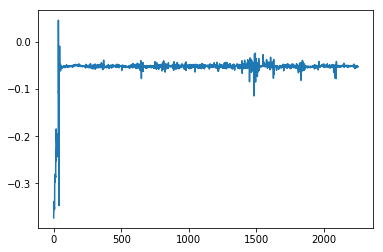

In [648]:
plt.plot(ay)

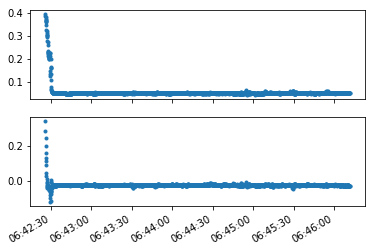

In [649]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

pitch = kalman_states[:, 0]
roll = kalman_states[:, 1]
ax1.plot(t, pitch, '.')
ax2.plot(t, roll, '.')
fig.autofmt_xdate()

In [650]:
accel_only = kalman_states.copy()

In [651]:
Q_acc = .01
Q_ang = .0001 * dt

number_of_timesteps = len(t)
number_of_states = 3

Q = np.array([
    [Q_ang, 0, 0],  
    [0, Q_ang, 0],   
    [0, 0, Q_ang],   
])    

R = np.array([
    [Q_acc, 0, 0],
    [0, Q_acc, 0],    
    [0, 0, Q_acc]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([np.pi/8, np.pi/8, 0])
P = np.array([
    [Q_ang, 0, 0],
    [0, Q_ang, 0],
    [0, 0, Q_ang],    
])
for time_index in range(number_of_timesteps):
    # Kalman step

    pitch, roll, yaw = mu     
    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        gx, gy, gz = u
        dyaw = gz * dt
        dpitch = gx * dt
        droll = gy * dt
        
        pitch, roll, yaw = mu
        
        total_R = R_(dyaw, dpitch, droll) @ R_(yaw, pitch, roll)
        yaw, pitch, roll = get_yaw_pitch_roll_from_R(total_R)
        mu = np.array([pitch, roll, yaw])
        
        return mu
    
    def h(mu):
        pitch, roll, yaw = mu
        return R_(0, pitch, roll) @ np.array([0, 0, -1])

    F = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])    
    
    z = np.array([ax_, ay_, az_])
    
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    H = -(np.array([
        [sb*sg, -cb*cg],
        [cb, 0],
        [-sb*cg, -cb*sg]     
    ]))

    # Predict
    u = np.vstack([gx, gy, gz]).T[time_index]
    mu_model = f(mu, u)
    P = F @ P @ F.T + Q

    # Update
    #y = z - h(mu)
    #K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model #+ K @ y
    #P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    #y = z - H @ mu # post-fit residual

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

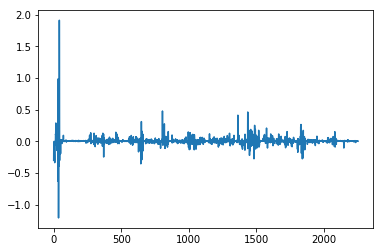

In [652]:
plt.plot(gy)

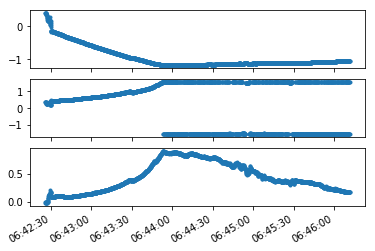

In [653]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

pitch = kalman_states[:, 0]
roll = kalman_states[:, 1]
yaw = kalman_states[:, 2]
ax1.plot(t, pitch, '.')
ax2.plot(t, roll, '.')
ax3.plot(t, yaw, '.')
fig.autofmt_xdate()

In [654]:
gyro_only = kalman_states.copy()

In [655]:
Q_acc = .001
Q_ang = .0001 * dt

number_of_timesteps = len(t)
number_of_states = 3

Q = np.array([
    [Q_ang, 0, 0],  
    [0, Q_ang, 0],   
    [0, 0, Q_ang],   
])    

R = np.array([
    [Q_acc, 0, 0],
    [0, Q_acc, 0],    
    [0, 0, Q_acc]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([np.pi/8, np.pi/8, 0])
P = np.array([
    [Q_ang, 0, 0],
    [0, Q_ang, 0],
    [0, 0, Q_ang],    
])
for time_index in range(number_of_timesteps):
    # Kalman step

    pitch, roll, yaw = mu     
    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        gx, gy, gz = u
        dyaw = gz * dt
        dpitch = gx * dt
        droll = gy * dt
        
        pitch, roll, yaw = mu
        
        total_R = R_(dyaw, dpitch, droll) @ R_(yaw, pitch, roll)
        yaw, pitch, roll = get_yaw_pitch_roll_from_R(total_R)
        mu = np.array([pitch, roll, yaw])
        
        return mu
    
    def h(mu):
        pitch, roll, yaw = mu
        return R_(0, pitch, roll) @ np.array([0, 0, -1])

    F = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])    
    
    z = np.array([ax_, ay_, az_])
    
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    H = -(np.array([
        [sb*sg, -cb*cg, 0],
        [cb, 0, 0],
        [-sb*cg, -cb*sg, 0]     
    ]))

    # Predict
    u = np.vstack([gx, gy, gz]).T[time_index]
    mu_model = f(mu, u)
    P = F @ P @ F.T + Q

    # Update
    y = z - h(mu)
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

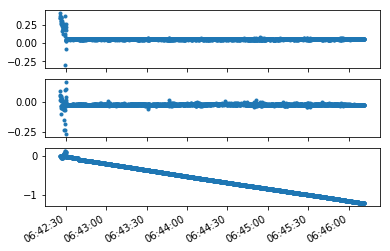

In [656]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

pitch = kalman_states[:, 0]
roll = kalman_states[:, 1]
yaw = kalman_states[:, 2]
ax1.plot(t, pitch, '.')
ax2.plot(t, roll, '.')
ax3.plot(t, yaw, '.')
fig.autofmt_xdate()

In [657]:
both = kalman_states.copy()

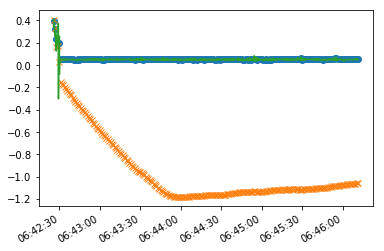

In [658]:
fig = plt.figure()
plt.plot(t[::10], accel_only[:, 0][::10], 'o')
plt.plot(t[::10], gyro_only[:, 0][::10], 'x')
plt.plot(t, both[:, 0])
fig.autofmt_xdate()

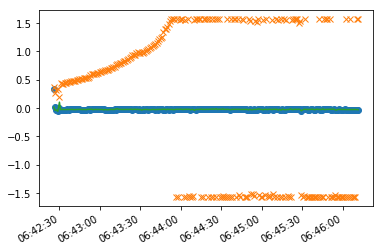

In [659]:
fig = plt.figure()
plt.plot(t[::10], accel_only[:, 1][::10], 'o')
plt.plot(t[::10], gyro_only[:, 1][::10], 'x')
plt.plot(t[::10], both[:, 1][::10])
fig.autofmt_xdate()